## Init

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns #Seaborn은 Matplotlib을 기반으로 다양한 색상 테마와 통계용 차트 등의 기능을 추가한 시각화 패키지, 약간 요소들간의 연관성을 비교하고자 할때 편리한듯?
import matplotlib.pyplot as plt
%matplotlib inline  
# %matplotlib inline 의 역할은 notebook을 실행한 브라우저에서 바로 그림을 볼 수 있게 해주는 것

from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras import Input, Model
from tensorflow.keras import Sequential
from tensorflow.keras.applications import resnet_v2
from keras.backend import int_shape
from tensorflow.keras import initializers
from tensorflow.keras.optimizers import *
import tensorflow_addons as tfa

from sklearn.utils import shuffle
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import MinMaxScaler

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
train = pd.read_csv('./train_V2.csv')
label = train['leaf_weight']
train.drop(['img_name'], axis=1, inplace=True)

test = pd.read_csv('./test_V2.csv')
test.drop(['img_name'], axis=1, inplace=True)

In [4]:
train.head()

,day_in_temp,night_in_temp,day_out_temp,night_out_temp,day_in_humi,night_in_humi,day_out_humi,night_out_humi,day_co2,night_co2,...,day_light,night_light,day_white_light,night_white_light,day_red_light,night_red_light,day_blue_light,night_blue_light,img_pixel,leaf_weight
0,18.625882,26.629242,42.220588,44.986970,78.413088,76.605303,2.660294,5.481818,559.897059,398.310606,...,25.772033,286.616797,1.263002,25.295875,1.197912,44.082734,0.0,0.0,7777.0,49.193
1,18.971176,27.916212,52.066765,35.233636,80.035735,74.764091,1.775000,6.395455,563.860294,378.133333,...,25.703781,286.602733,1.248401,25.295875,1.184090,44.035264,0.0,0.0,8004.0,59.764
2,19.191912,27.503182,47.165588,30.250455,80.032647,74.511970,2.661765,5.786364,569.777941,385.709091,...,25.790234,286.752750,1.243534,25.270802,1.174875,44.139698,0.0,0.0,8336.0,72.209
3,18.338971,24.238939,59.114559,56.608939,80.903382,78.914545,1.773529,4.872727,560.339706,387.825758,...,25.644629,286.827758,1.255701,25.245729,1.188697,44.104095,0.0,0.0,8581.0,85.737
4,19.151765,25.195454,67.153970,68.003636,82.164706,80.358939,1.773529,5.786364,565.273529,393.254545,...,25.612778,286.846510,1.270302,25.288353,1.202519,44.087481,0.0,0.0,8969.0,102.537


Index(['day_in_temp', 'night_in_temp', 'day_out_temp', 'night_out_temp',
       'day_in_humi', 'night_in_humi', 'day_out_humi', 'night_out_humi',
       'day_co2', 'night_co2', 'day_ec', 'night_ec', 'day_water',
       'night_water', 'day_white', 'night_white', 'day_red', 'night_red',
       'day_blue', 'night_blue', 'day_cool_temp', 'night_cool_temp',
       'day_cooling', 'night_cooling', 'day_heat_temp', 'night_heat_temp',
       'day_heating', 'night_heating', 'day_light', 'night_light',
       'day_white_light', 'night_white_light', 'day_red_light',
       'night_red_light', 'day_blue_light', 'night_blue_light', 'img_pixel',
       'leaf_weight'],
      dtype='object')


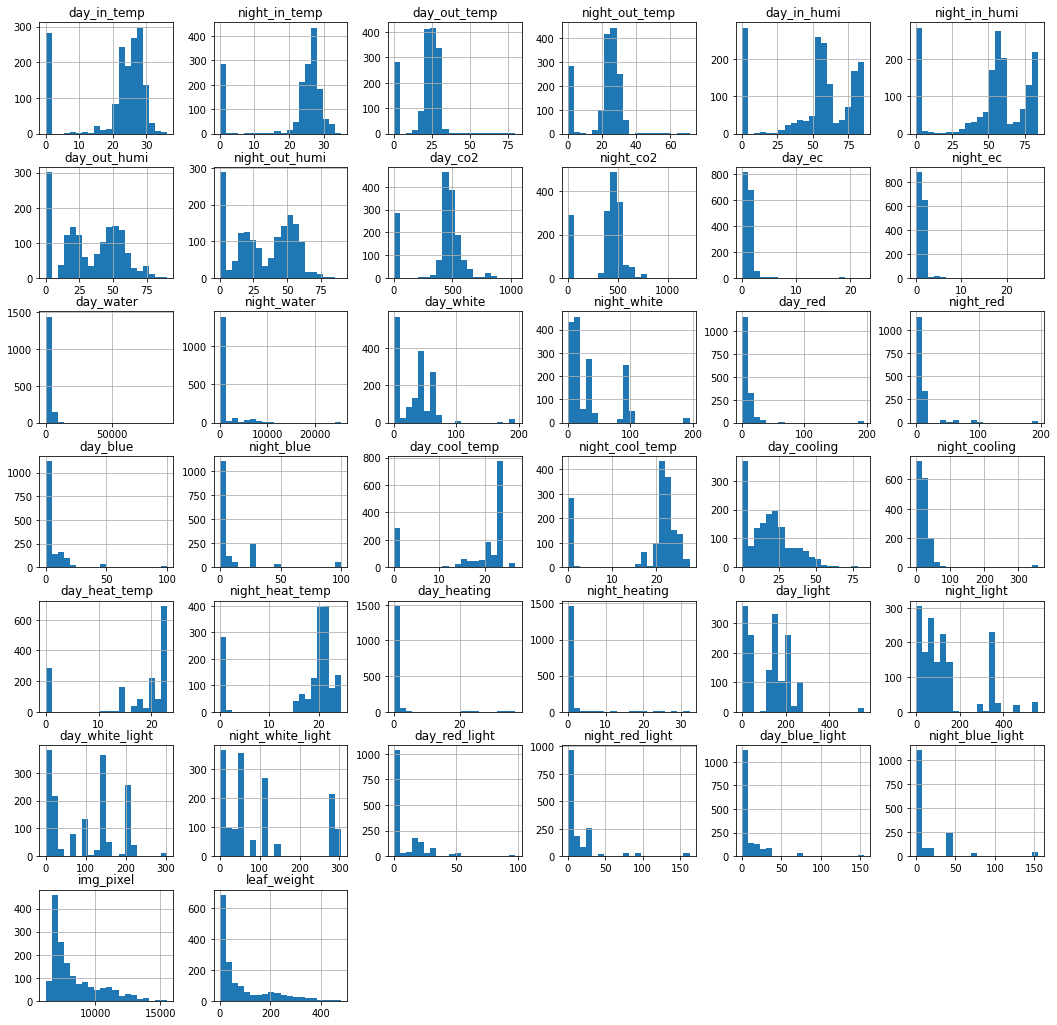

In [5]:
plot_cols_list = train.columns[0:]
print(plot_cols_list)

train[plot_cols_list].hist(figsize=(18,18), grid = True, layout = (7,6), bins = 20)
plt.show()

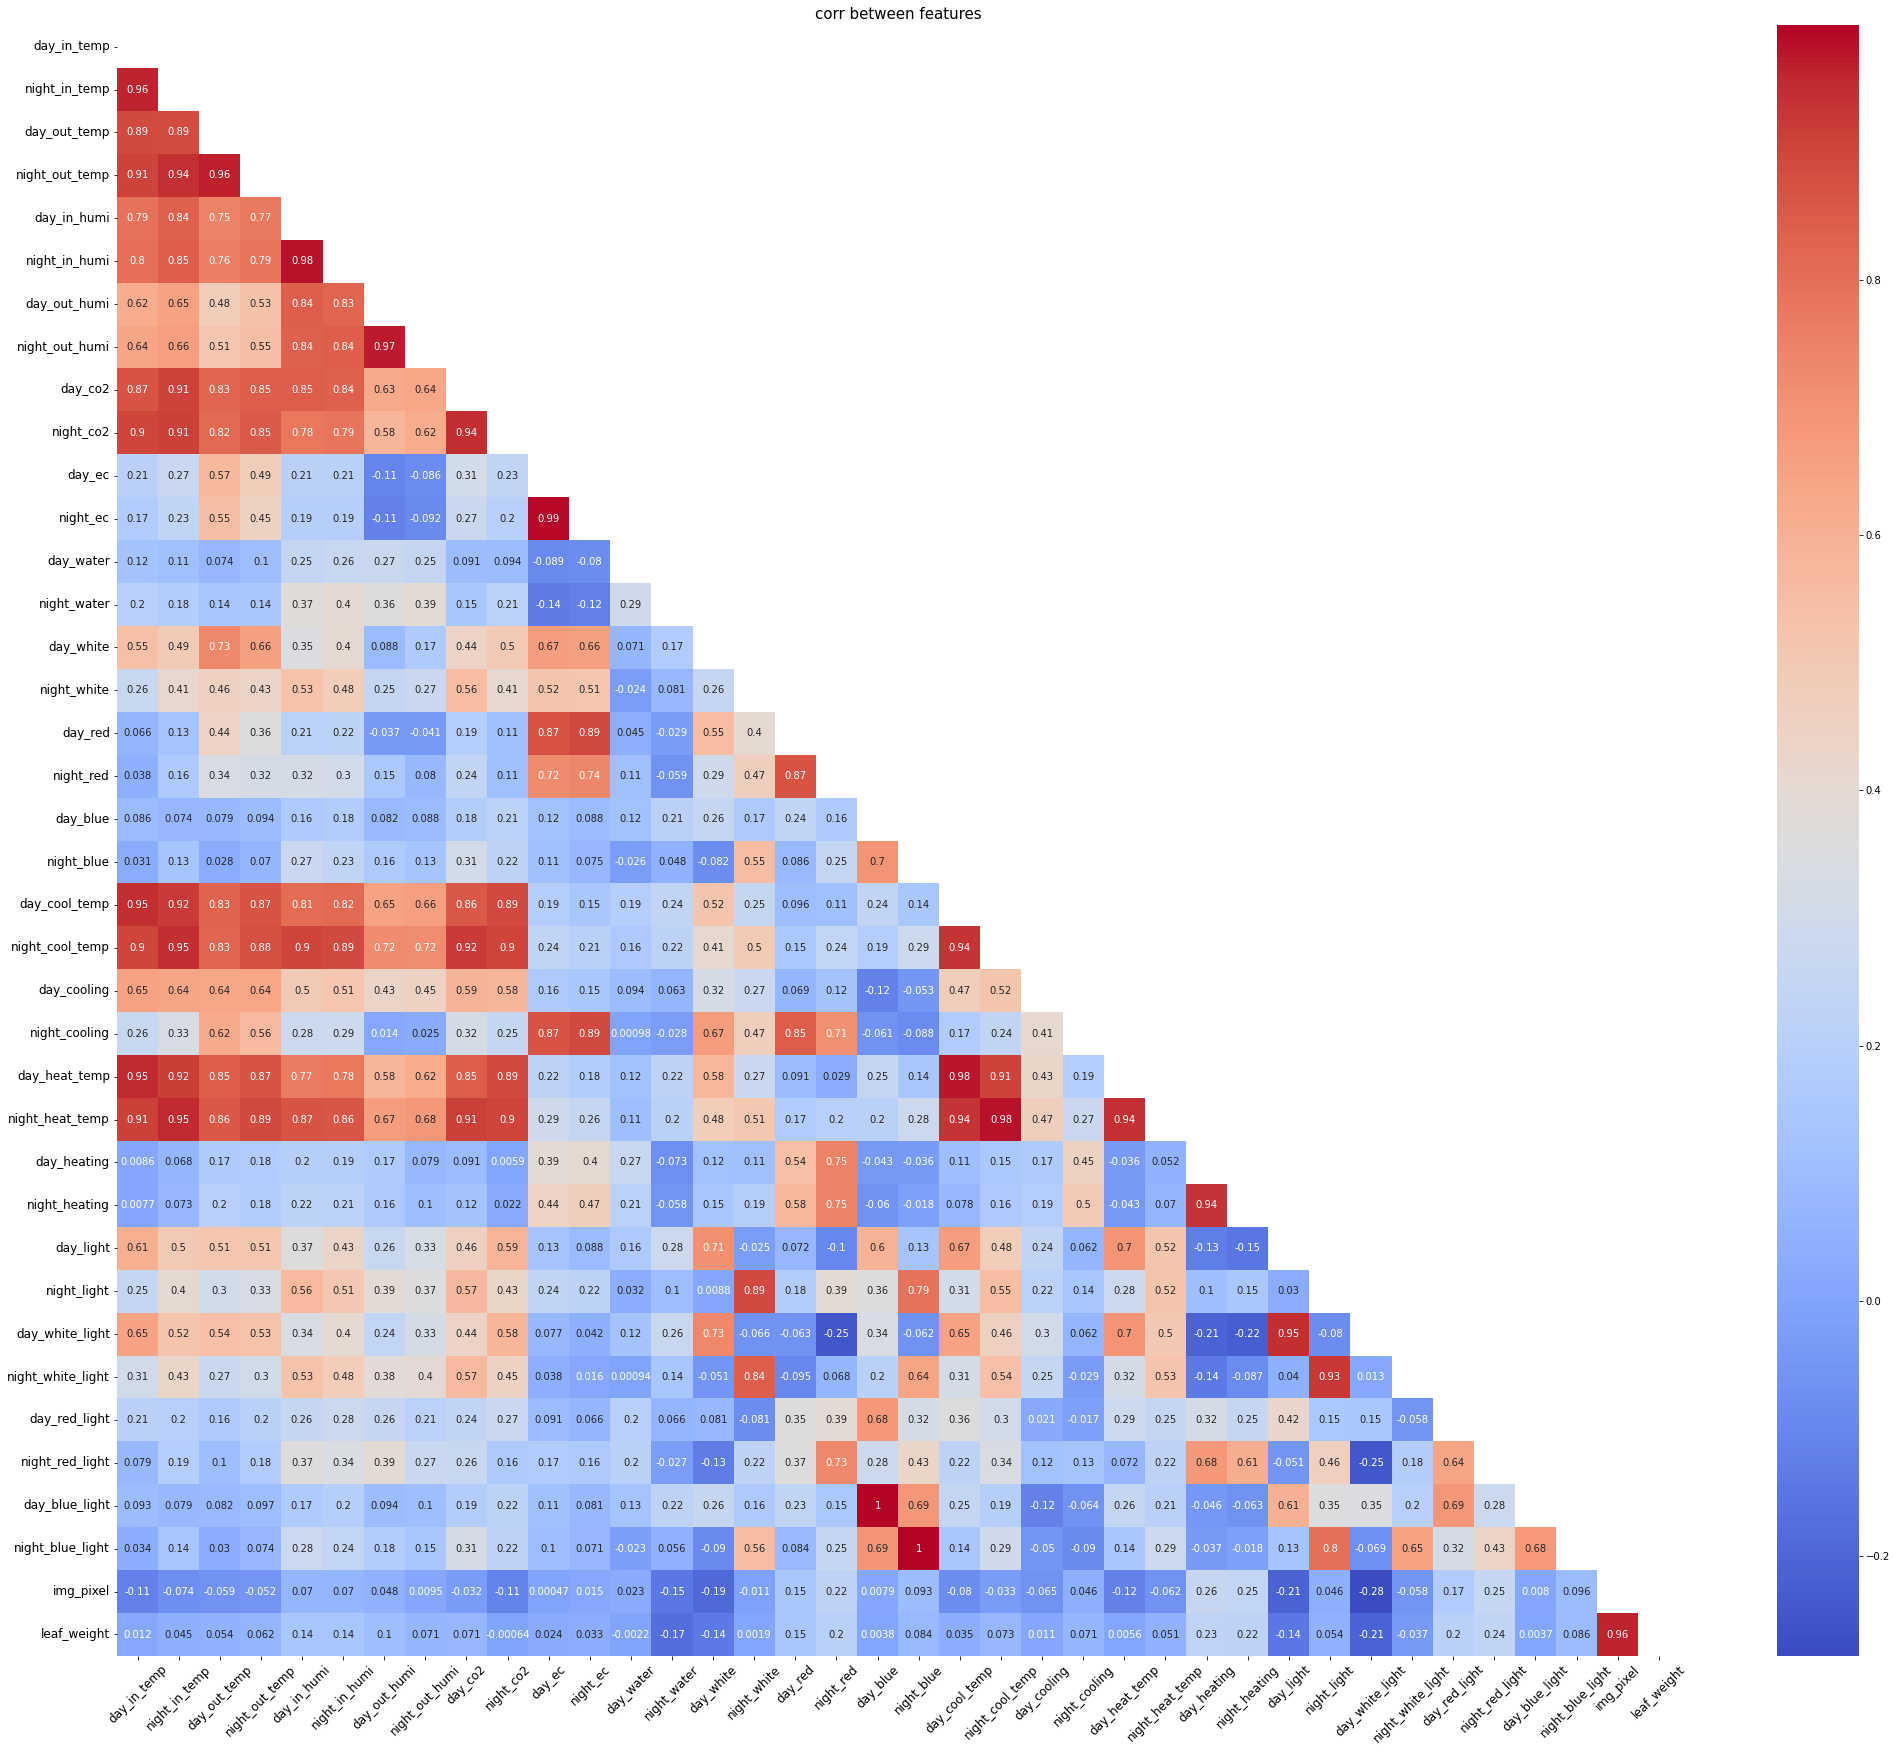

In [6]:
def corr_heat(df):
    plt.figure(figsize=(35,30))

    corr_df = df.corr()
    #display(corr_df)

    mask = np.zeros_like(corr_df)
    mask[np.triu_indices_from(mask)] = 1
    heat_map = sns.heatmap(corr_df, annot=True, mask = mask, cmap='coolwarm')
    heat_map.set_xticklabels(heat_map.get_xticklabels(), fontsize=12, rotation=45)
    heat_map.set_yticklabels(heat_map.get_yticklabels(), fontsize=12)
    plt.title('corr between features', fontsize=15)
    plt.show()
    
corr_heat(train[plot_cols_list])

## 이상치 제거

In [7]:
idx = train[train["night_in_temp"]==0].index

In [8]:
print(idx)

Int64Index([  18,   19,   95,   96,   97,   98,   99,  100,  101,  102,
            ...
            1553, 1554, 1555, 1556, 1557, 1558, 1559, 1560, 1561, 1562],
           dtype='int64', length=283)


In [9]:
train = train.drop(index = idx, axis = 0)
label = label.drop(index = idx, axis = 0)

## 파생변수 생성

In [10]:
#train = train[train.columns[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,18,16,17]]]

In [11]:
columns = plot_cols_list[:-2]

In [12]:
for col in columns : 
    train[col] = train[col]*train['img_pixel']
    test[col] = test[col]*test['img_pixel']

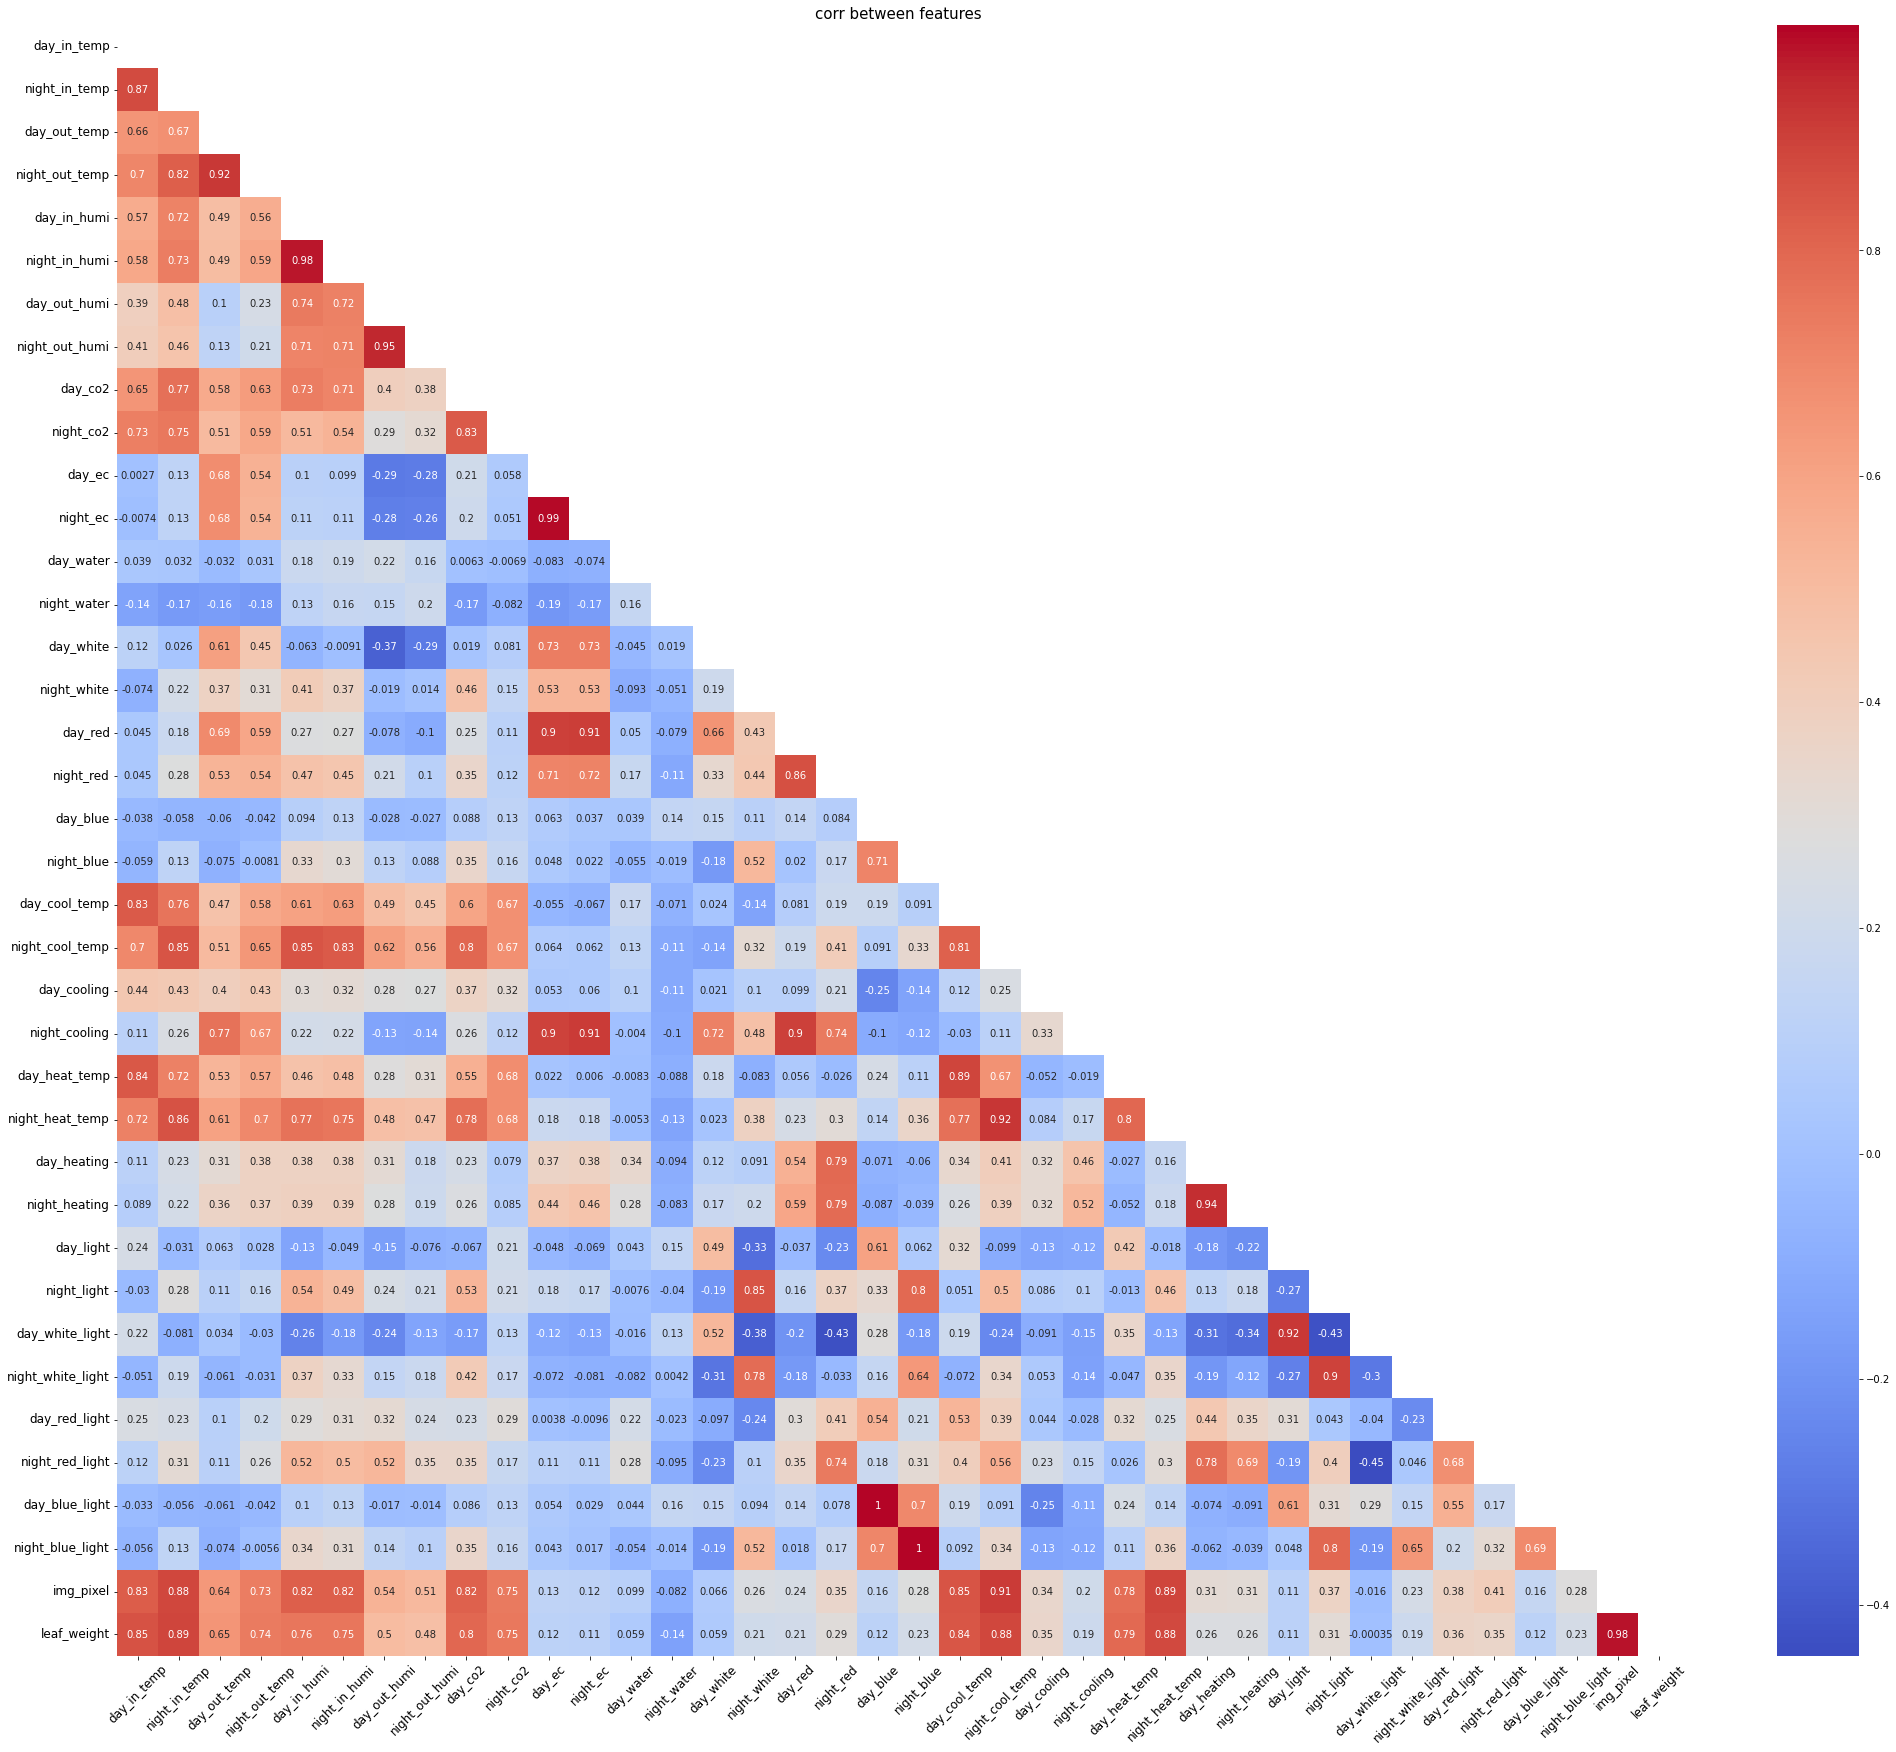

In [13]:
def corr_heat(df):
    plt.figure(figsize=(35,30))

    corr_df = df.corr()
    #display(corr_df)

    mask = np.zeros_like(corr_df)
    mask[np.triu_indices_from(mask)] = 1
    heat_map = sns.heatmap(corr_df, annot=True, mask = mask, cmap='coolwarm')
    heat_map.set_xticklabels(heat_map.get_xticklabels(), fontsize=12, rotation=45)
    heat_map.set_yticklabels(heat_map.get_yticklabels(), fontsize=12)
    plt.title('corr between features', fontsize=15)
    plt.show()

plot_cols_list = train.columns[0:]
corr_heat(train[plot_cols_list])

In [14]:
train.drop(['img_pixel'], axis=1, inplace=True)
test.drop(['img_pixel'], axis=1, inplace=True)  

In [15]:
def abcd1(df,col1,col2,set_col,df_update = False, test = False):
    result1 = []
    df[set_col] = 2*df[col1]+df[col2]
    result = df.set_index(set_col).reset_index().corr()[set_col]['leaf_weight']
    result1.append(result)
    df[set_col] = 2*df[col1]-df[col2]
    result = df.set_index(set_col).reset_index().corr()[set_col]['leaf_weight']
    result1.append(result)
    df[set_col] = 2*df[col1]/df[col2]
    result = df.set_index(set_col).reset_index().corr()[set_col]['leaf_weight']
    result1.append(result)
    df[set_col] = 2*df[col1]*df[col2]
    result = df.set_index(set_col).reset_index().corr()[set_col]['leaf_weight']
    result1.append(result)
    df[set_col] =3*df[col1]+df[col2]
    result = df.set_index(set_col).reset_index().corr()[set_col]['leaf_weight']
    result1.append(result)
    df[set_col] = 3*df[col1]-df[col2]
    result = df.set_index(set_col).reset_index().corr()[set_col]['leaf_weight']
    result1.append(result)
    df[set_col] = 3*df[col1]/df[col2]
    result = df.set_index(set_col).reset_index().corr()[set_col]['leaf_weight']
    result1.append(result)
    df[set_col] = 3*df[col1]*df[col2]
    result = df.set_index(set_col).reset_index().corr()[set_col]['leaf_weight']
    result1.append(result)
    max_corr = 0
    for n, i in enumerate(result1):
        if max_corr < abs(i):
            max_corr = abs(i)
            num = n
            
    if df_update != False:

        if num == 0:
            df[set_col] = 2*df[col1]+df[col2]
            test[set_col] = 2*test[col1]+test[col2]
        elif num == 1:
            df[set_col] = 2*df[col1]-df[col2]
            test[set_col] = 2*test[col1]-test[col2]
        elif num == 2:
            df[set_col] = 2*df[col1]/df[col2]
            test[set_col] = 2*test[col1]/test[col2]
        elif num == 3:
            df[set_col] = 2*df[col1]*df[col2]
            test[set_col] = 2*test[col1]*test[col2]
        if num == 4:
            df[set_col] = 3*df[col1]+df[col2]
            test[set_col] = 3*test[col1]+test[col2]
        elif num == 5:
            df[set_col] = 3*df[col1]-df[col2]
            test[set_col] = 3*test[col1]-test[col2]
        elif num == 6:
            df[set_col] = 3*df[col1]/df[col2]
            test[set_col] = 3*test[col1]/test[col2]
        elif num == 7:
            df[set_col] = 3*df[col1]*df[col2]
            test[set_col] = 3*test[col1]*test[col2]

        return df, test
    else:
        return max_corr

In [16]:
#10~19
#22~23
#26~35
max_result = 0
max_result_total = 0
i = 1

X_features = []
for i in train.columns[10:20]:
    X_features.append(i)
    
for i in train.columns[22:24]:
    X_features.append(i)
    
for i in train.columns[26:36]:
    X_features.append(i)


for col1 in X_features:
    for col2 in X_features: 
        if (col1=='leaf_weight')|(col2=='leaf_weight')|(col1=='new1')|(col2=='new1'):
            continue
        else:
            result = abcd1(train, col1, col2,'new1')
#             print(result,col1,col2)
            if max_result < abs(result):
                max_result = result
                columns = [col1, col2]
                print(f'{max_result}   {columns}')
df,test = abcd1(train,columns[0],columns[1],'new1',df_update=True,test = test)

0.1151140408874143   ['day_ec', 'day_ec']
0.12273430334074192   ['day_ec', 'night_ec']
0.12347981984058985   ['day_ec', 'day_water']
0.1430060188390552   ['day_ec', 'night_water']
0.20652276306722528   ['day_ec', 'night_white']
0.23742378257324426   ['day_ec', 'day_red']
0.31061903511127514   ['day_ec', 'night_red']
0.36045268927736396   ['day_ec', 'day_cooling']
0.3811455306105389   ['day_ec', 'day_red_light']
0.4193925095378916   ['day_blue', 'day_red']
0.4235501593996032   ['day_blue', 'day_red_light']
0.44337998760071823   ['day_cooling', 'night_blue']
0.4751145902087908   ['day_cooling', 'day_red_light']


In [17]:
train = train[train.columns[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,37,36]]]

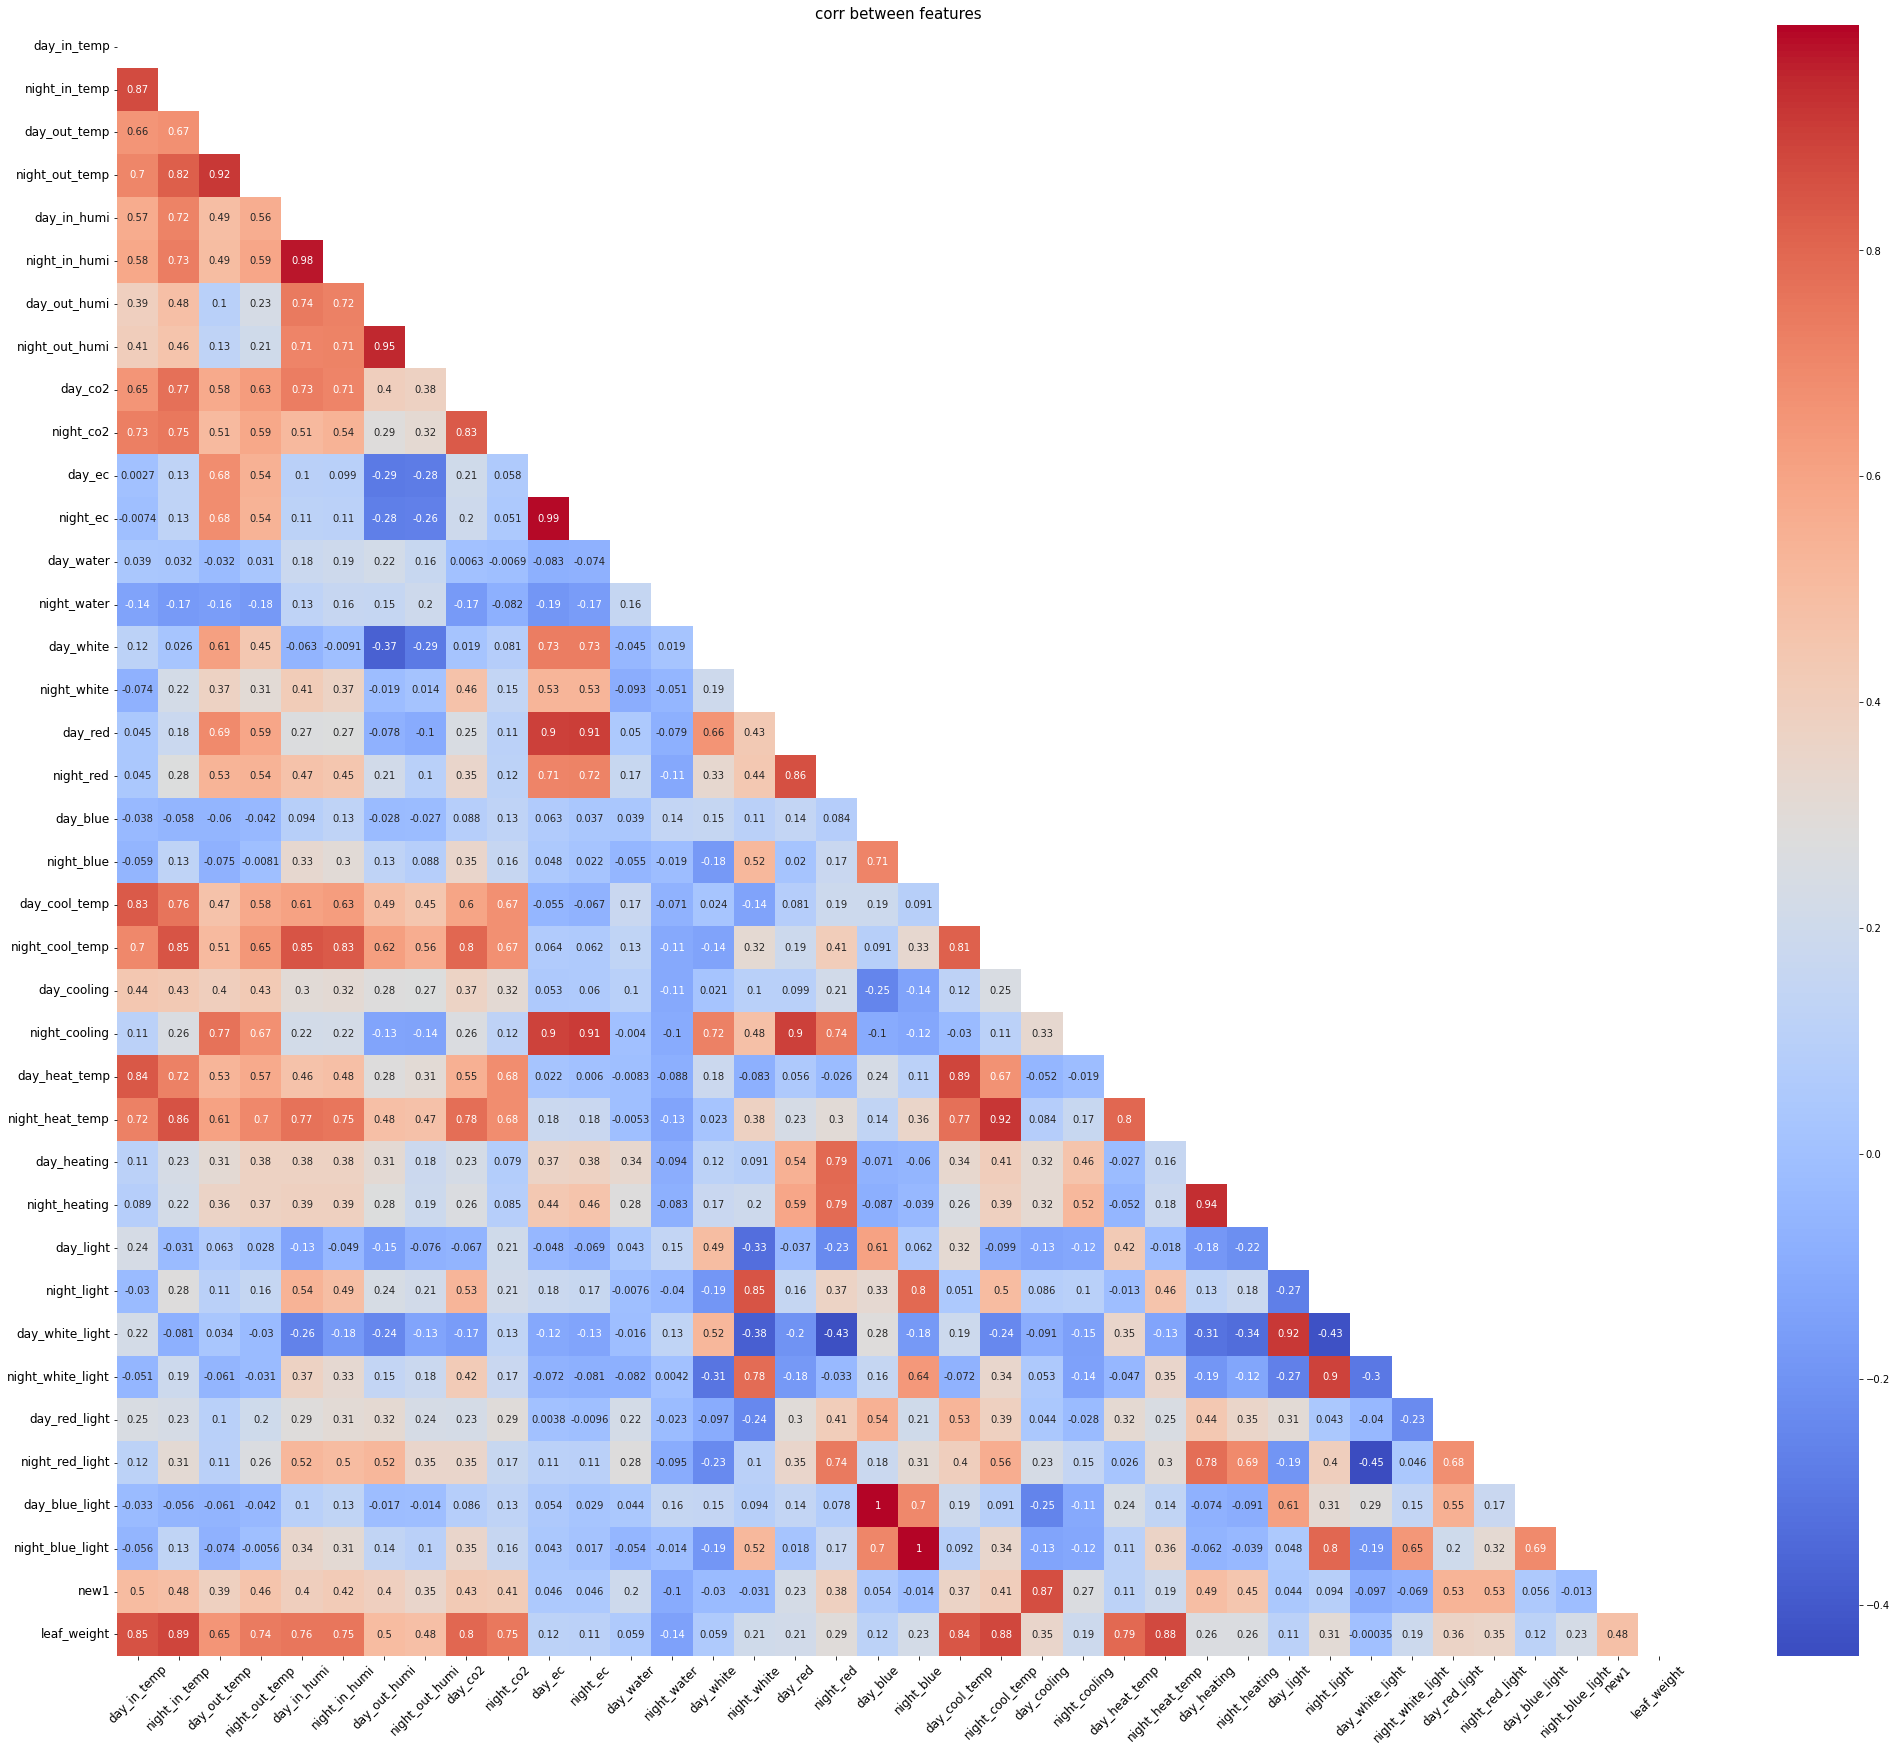

In [18]:
def corr_heat(df):
    plt.figure(figsize=(35,30))

    corr_df = df.corr()
    #display(corr_df)

    mask = np.zeros_like(corr_df)
    mask[np.triu_indices_from(mask)] = 1
    heat_map = sns.heatmap(corr_df, annot=True, mask = mask, cmap='coolwarm')
    heat_map.set_xticklabels(heat_map.get_xticklabels(), fontsize=12, rotation=45)
    heat_map.set_yticklabels(heat_map.get_yticklabels(), fontsize=12)
    plt.title('corr between features', fontsize=15)
    plt.show()

plot_cols_list = train.columns[0:]
corr_heat(train[plot_cols_list])

In [19]:
#10~19
#22~23
#26~35
max_result = 0
max_result_total = 0
i = 1
X_features = train.columns

for col1 in X_features :
    for col2 in X_features : 
        if (col1=='leaf_weight')|(col2=='leaf_weight')|(col1=='new2')|(col2=='new2'):
            continue
        else:
            result = abcd1(train, col1, col2,'new2')
            #print(result,col1,col2)
            if max_result < abs(result):
                max_result = result
                columns = [col1, col2]
                print(f'{max_result}   {columns}')
df,test = abcd1(train,columns[0],columns[1],'new2',df_update=True,test = test)

0.8827378002364132   ['day_in_temp', 'day_in_temp']
0.9251849374891283   ['day_in_temp', 'night_in_temp']
0.9541697727449955   ['day_in_temp', 'night_cool_temp']


In [20]:
train = train[train.columns[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,38,37]]]

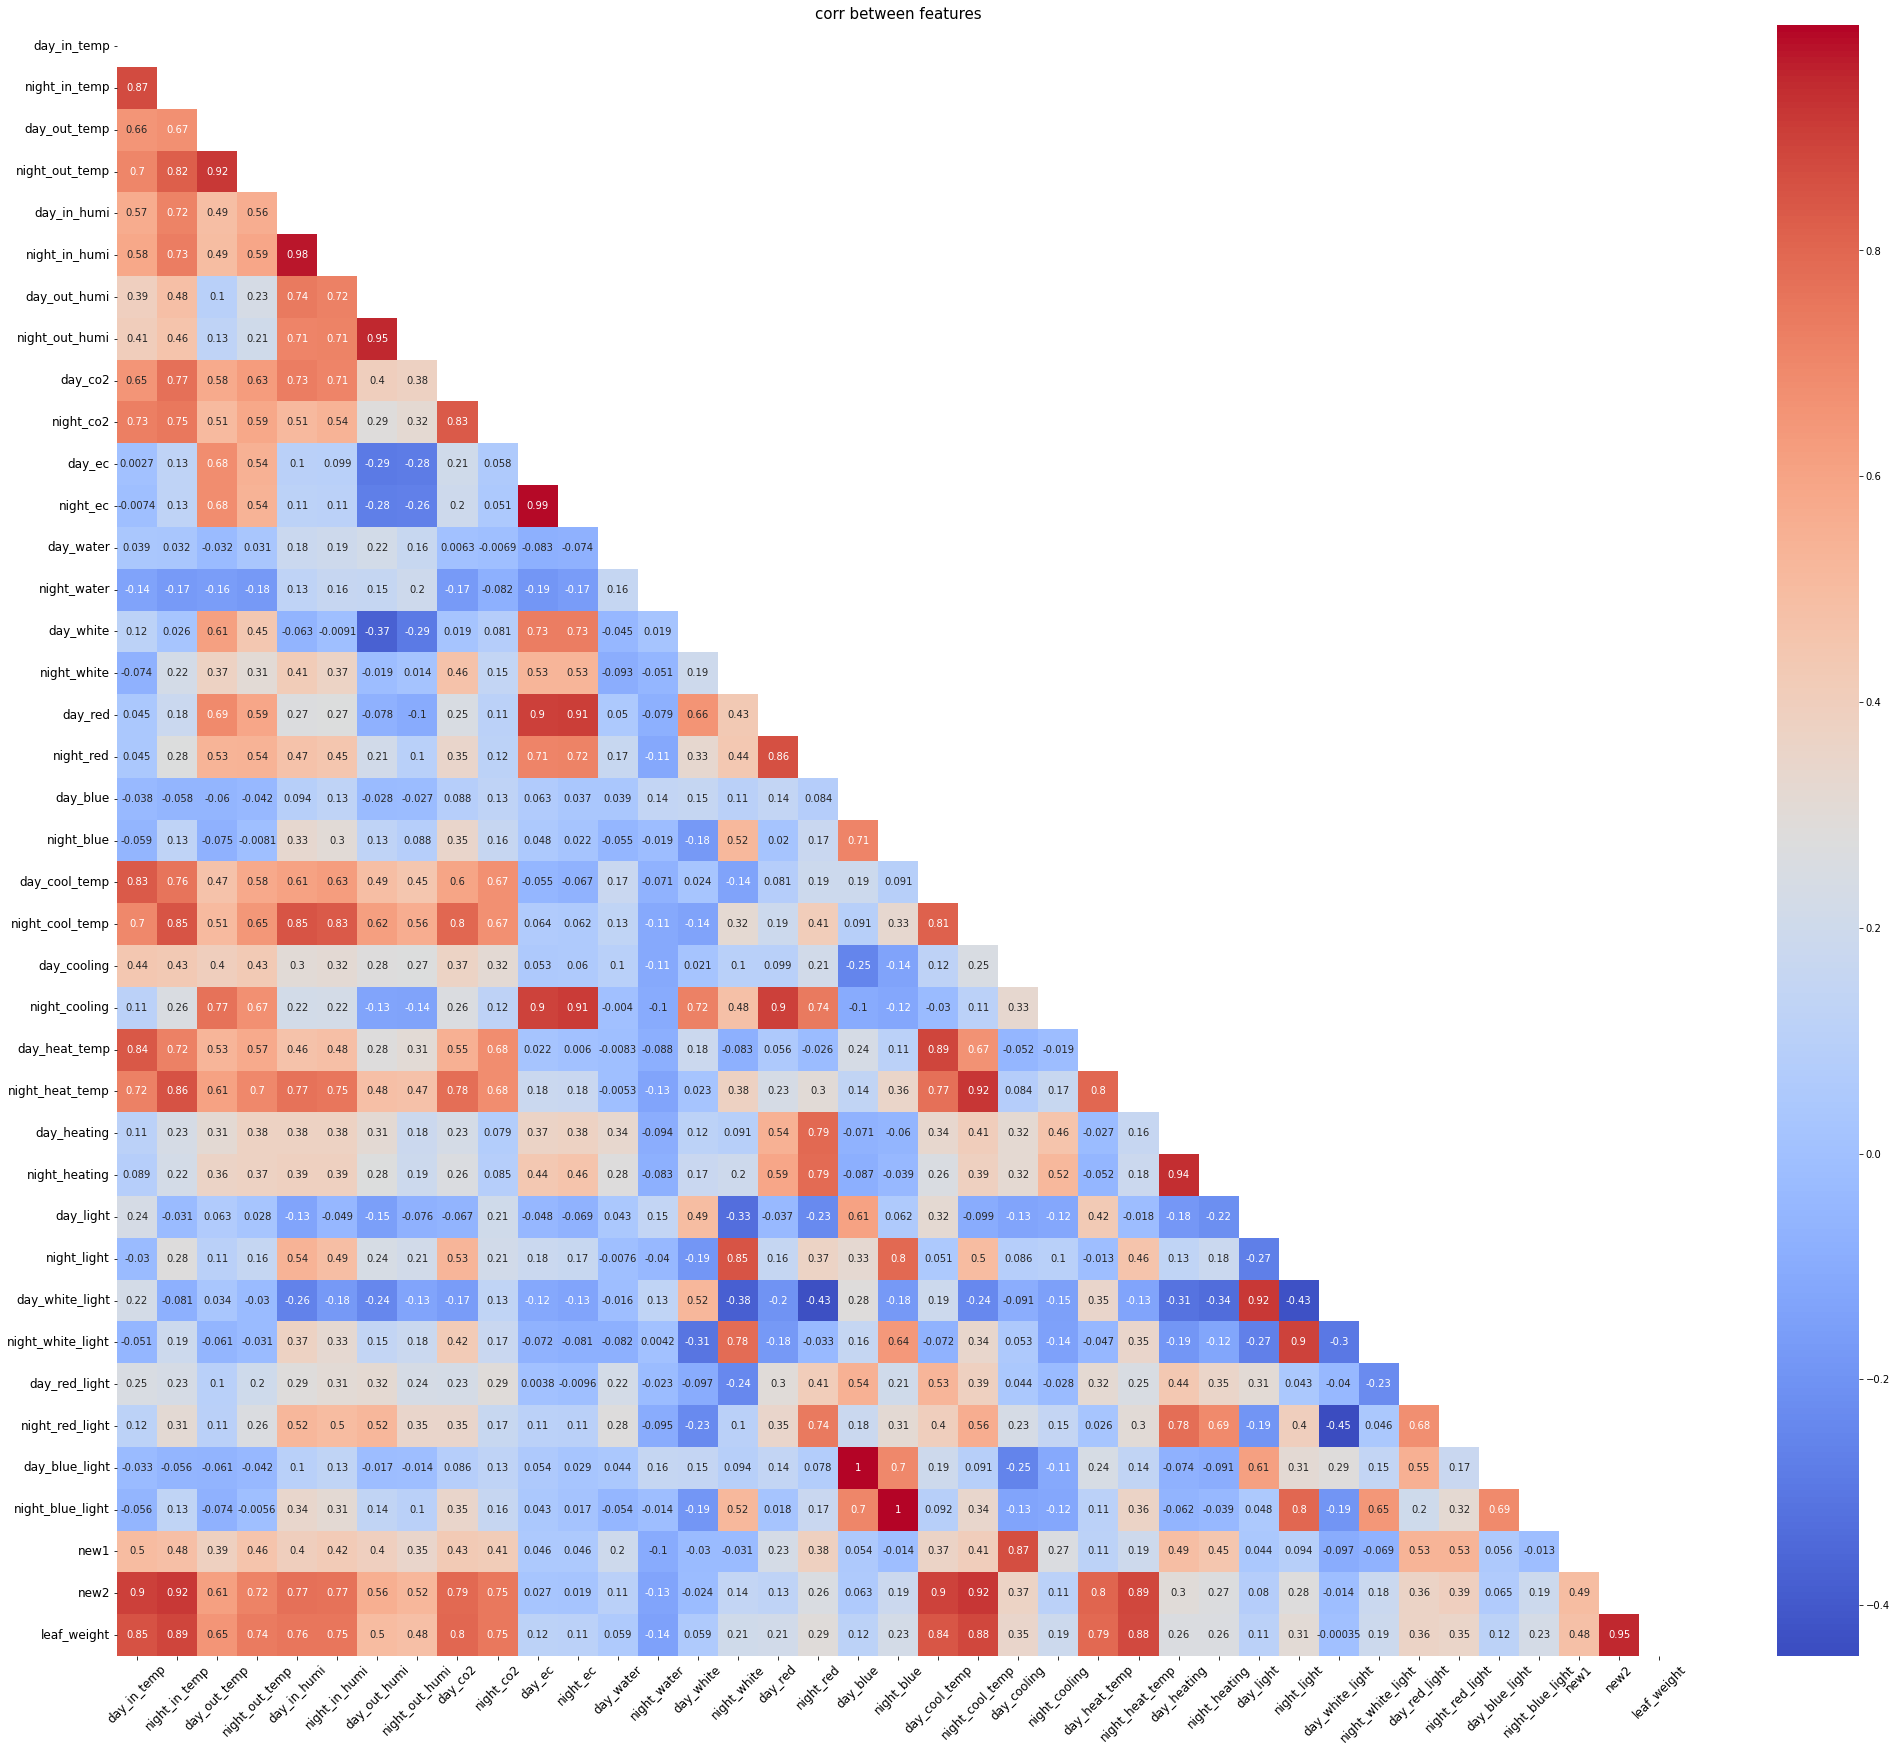

In [21]:
def corr_heat(df):
    plt.figure(figsize=(35,30))

    corr_df = df.corr()
    #display(corr_df)

    mask = np.zeros_like(corr_df)
    mask[np.triu_indices_from(mask)] = 1
    heat_map = sns.heatmap(corr_df, annot=True, mask = mask, cmap='coolwarm')
    heat_map.set_xticklabels(heat_map.get_xticklabels(), fontsize=12, rotation=45)
    heat_map.set_yticklabels(heat_map.get_yticklabels(), fontsize=12)
    plt.title('corr between features', fontsize=15)
    plt.show()

plot_cols_list = train.columns[0:]
corr_heat(train[plot_cols_list])

In [24]:
train.drop(train.columns[[10,11,12,13,14,15,16,17,18,19,22,23,26,27,28,29,30,31,32,33,34,35]], axis=1, inplace=True)
test.drop(test.columns[[10,11,12,13,14,15,16,17,18,19,22,23,26,27,28,29,30,31,32,33,34,35]], axis=1, inplace=True)

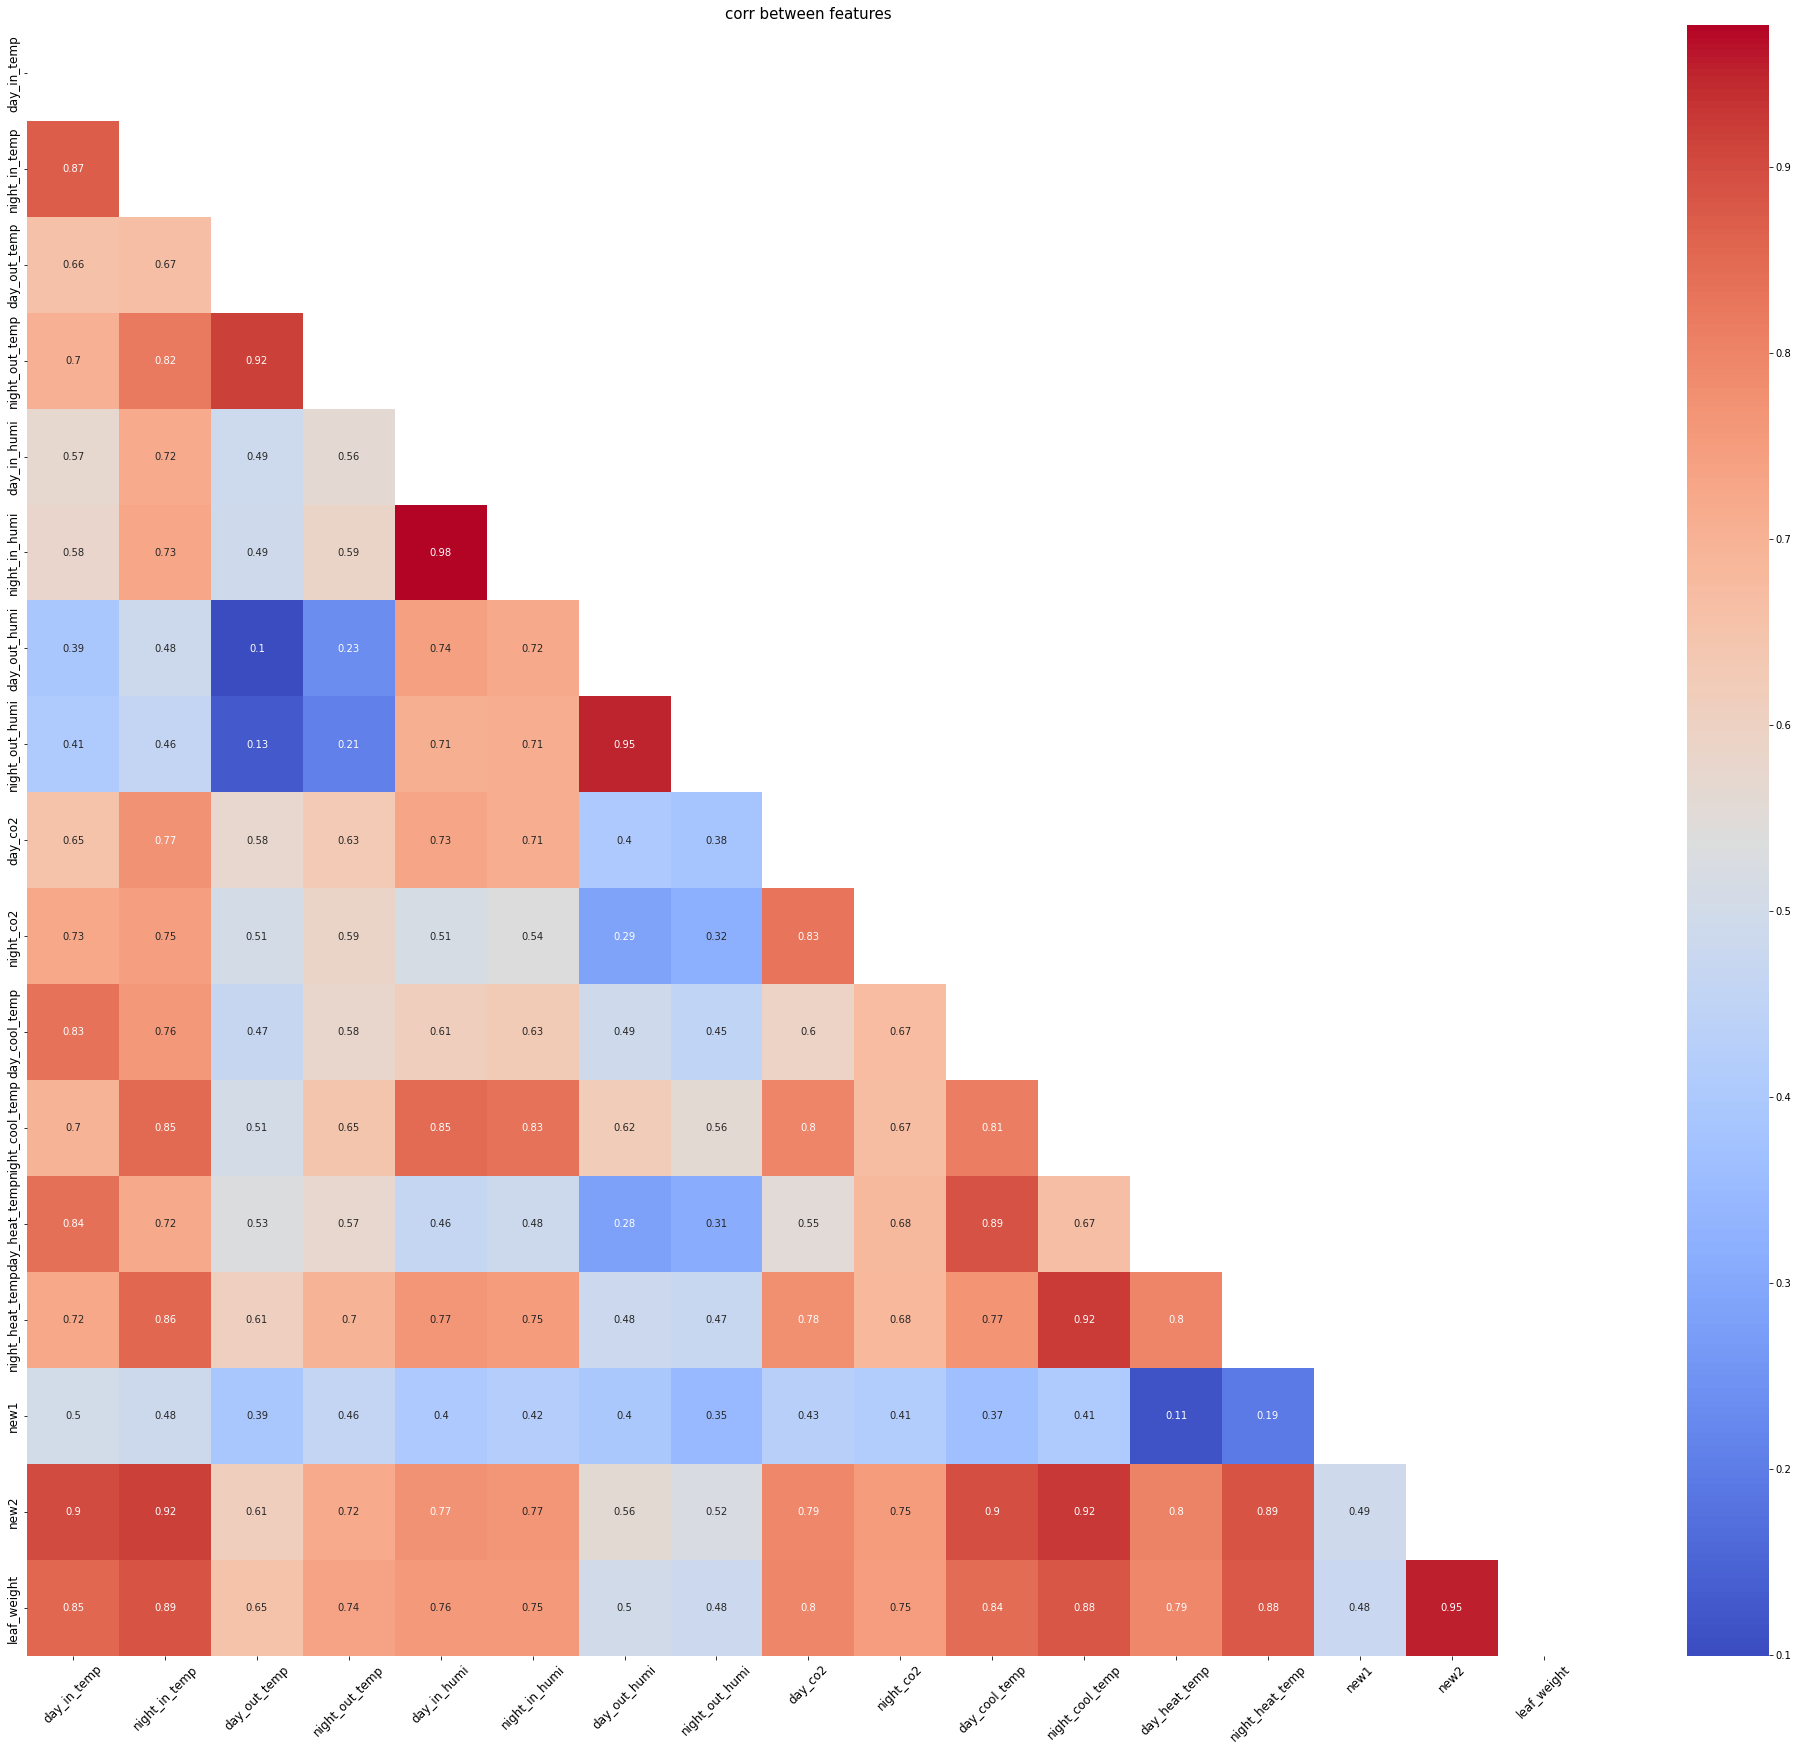

In [25]:
def corr_heat(df):
    plt.figure(figsize=(35,30))

    corr_df = df.corr()
    #display(corr_df)

    mask = np.zeros_like(corr_df)
    mask[np.triu_indices_from(mask)] = 1
    heat_map = sns.heatmap(corr_df, annot=True, mask = mask, cmap='coolwarm')
    heat_map.set_xticklabels(heat_map.get_xticklabels(), fontsize=12, rotation=45)
    heat_map.set_yticklabels(heat_map.get_yticklabels(), fontsize=12)
    plt.title('corr between features', fontsize=15)
    plt.show()

plot_cols_list = train.columns[0:]
corr_heat(train[plot_cols_list])

## 전처리

In [26]:
train.drop(['leaf_weight'], axis=1, inplace=True)
print(train.columns.values)

['day_in_temp' 'night_in_temp' 'day_out_temp' 'night_out_temp'
 'day_in_humi' 'night_in_humi' 'day_out_humi' 'night_out_humi' 'day_co2'
 'night_co2' 'day_cool_temp' 'night_cool_temp' 'day_heat_temp'
 'night_heat_temp' 'new1' 'new2']


In [27]:
train, label = shuffle(train, label, random_state = 3)

In [28]:
M_label = max(label)

In [29]:
label=label/M_label

In [30]:
label.describe()

count    1309.000000
mean        0.175633
std         0.224695
min         0.000000
25%         0.012449
50%         0.071522
75%         0.276513
max         1.000000
Name: leaf_weight, dtype: float64

In [31]:
scaler = MinMaxScaler()
scaler.fit(train)
train_output = scaler.transform(train)
test_output = scaler.transform(test)

train_output = pd.DataFrame(train_output, columns=train.columns, index=list(train.index.values))
train_output.describe()

,day_in_temp,night_in_temp,day_out_temp,night_out_temp,day_in_humi,night_in_humi,day_out_humi,night_out_humi,day_co2,night_co2,day_cool_temp,night_cool_temp,day_heat_temp,night_heat_temp,new1,new2
count,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000
mean,0.484518,0.528519,0.175495,0.266871,0.438704,0.447610,0.314281,0.303119,0.313983,0.432857,0.395751,0.502490,0.376108,0.491511,0.244129,0.311615
std,0.145863,0.144852,0.097651,0.093659,0.183249,0.177128,0.181217,0.168233,0.145887,0.122049,0.169482,0.145773,0.158805,0.134818,0.148738,0.160693
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.393677,0.435597,0.121974,0.207289,0.309869,0.327137,0.159877,0.156745,0.212611,0.348399,0.301172,0.408781,0.295433,0.403590,0.144714,0.208379
50%,0.456488,0.488339,0.154788,0.243658,0.409890,0.415971,0.307913,0.304806,0.267302,0.403630,0.348516,0.458182,0.339291,0.445790,0.220174,0.248693
75%,0.563840,0.601626,0.205321,0.303453,0.537522,0.548941,0.407823,0.406313,0.386140,0.497462,0.462719,0.557403,0.435386,0.550023,0.314460,0.358822
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [32]:
train = train_output
test = test_output

In [33]:
n = round((len(train)*0.85))

x_train = train[:n]
y_train = label[:n]

x_val = train[n:]
y_val = label[n:]

print(f'x_train shape => {x_train.shape}     y_train shape =>{y_train.shape}')
print(f'x_val shape => {x_val.shape}     y_val shape =>{y_val.shape}')
print(f'test shape => {test.shape}')

x_train shape => (1113, 16)     y_train shape =>(1113,)
x_val shape => (196, 16)     y_val shape =>(196,)
test shape => (460, 16)


In [62]:
def bangdoon(input_shape):
    
    input = Input(shape=input_shape)
    model = Dense(units=16, activation='relu')(input)
    model = Dropout(0.25)(model)
    model = Dense(units=32, activation='relu')(input)
    model = Dropout(0.25)(model)
    model = Dense(units=64, activation='relu')(input)
    model = Dropout(0.5)(model)
    model = Dense(units=64, activation='relu')(input)
    model = Dropout(0.5)(model)
    output = Dense(units=1, activation='sigmoid')(model) # 0~1 
    model = Model(inputs=input, outputs=output)

    return model

In [63]:
model = bangdoon(x_train.shape[1:])
opt = Nadam(learning_rate=0.001)

# step = tf.Variable(0, trainable=False)
# schedule = tf.optimizers.schedules.PiecewiseConstantDecay(
#     [100, 150], [1e-0, 1e-1, 1e-2])
# # lr and wd can be a function or a tensor
# lr = 0.001 * schedule(step)
# wd = lambda: 1e-3 * schedule(step)
# opt=tfa.optimizers.AdamW(learning_rate=lr, weight_decay=wd)

model.compile(loss='mean_squared_error',  #mse를 쓰면 영향력이 적은 특징들에 제곱을 주어 0에 가깝게 만들어줌
             optimizer=opt,
             #metrics=['mae']
             )  

In [64]:
# 학습 자동 중단 설정
my_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode='min')

history = model.fit(
    x=x_train, y=y_train,
    validation_data = (x_val, y_val),
    epochs=1500,
    batch_size=20,
    verbose=1,
    callbacks = my_callback,
)

p_test =[]
p_test_tmp = model.predict(x_val)
rmse_test = np.sqrt(np.mean(np.power(p_test_tmp.reshape(-1, ) - y_val, 2)))
print(f'model RMSE Test = {rmse_test}')

p_test = p_test_tmp

Epoch 1/1500
56/56 [==============================] - 0s 3ms/step - loss: 0.1079 - val_loss: 0.0770
Epoch 2/1500
56/56 [==============================] - 0s 3ms/step - loss: 0.0750 - val_loss: 0.0728
Epoch 3/1500
56/56 [==============================] - 0s 3ms/step - loss: 0.0694 - val_loss: 0.0671
Epoch 4/1500
56/56 [==============================] - 0s 4ms/step - loss: 0.0621 - val_loss: 0.0568
Epoch 5/1500
56/56 [==============================] - 0s 5ms/step - loss: 0.0533 - val_loss: 0.0443
Epoch 6/1500
56/56 [==============================] - 0s 2ms/step - loss: 0.0420 - val_loss: 0.0305
Epoch 7/1500
56/56 [==============================] - 0s 3ms/step - loss: 0.0320 - val_loss: 0.0206
Epoch 8/1500
56/56 [==============================] - 0s 4ms/step - loss: 0.0235 - val_loss: 0.0143
Epoch 9/1500
56/56 [==============================] - 0s 3ms/step - loss: 0.0179 - val_loss: 0.0103
Epoch 10/1500
56/56 [==============================] - 0s 2ms/step - loss: 0.0152 - val_loss: 0.0079

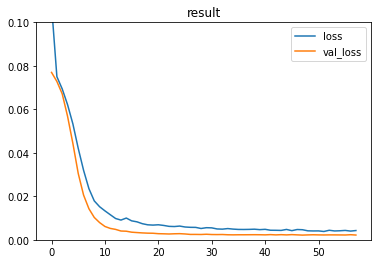

In [66]:
pd.DataFrame(history.history)[['loss', 'val_loss']].plot().set_ylim(0.0,0.1)

#pd.DataFrame(history.history)[['loss']].plot().set_ylim(0.0,0.1)
plt.title('result')
plt.show()

In [67]:
y_test = model.predict(test)

y_test = y_test*M_label

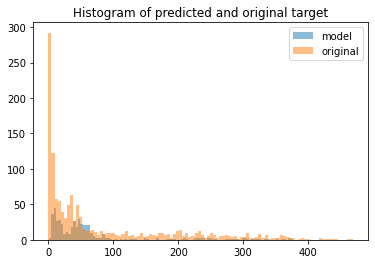

In [68]:
# histogram of scaled target
label_fix = label*M_label
plt.hist(y_test, bins=100, label='model', alpha=0.5)
plt.hist(label_fix, bins=100, label='original', alpha=0.5)

plt.title('Histogram of predicted and original target')
plt.legend()
plt.show()

In [69]:
submission = pd.read_csv('./sample_submission.csv')
submission['leaf_weight'] = y_test
submission.to_csv('./submit/make_col_10.csv', index=False)